In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pwlf
print(pwlf.__version__)
%matplotlib inline

2.1.0


In [2]:
# your data
y = np.array([0.00000000e+00, 9.69801700e-03, 2.94350340e-02,
              4.39052750e-02, 5.45343950e-02, 6.74104940e-02,
              8.34831790e-02, 1.02580042e-01, 1.22767939e-01,
              1.42172312e-01, 0.00000000e+00, 8.58600000e-06,
              8.31543400e-03, 2.34184100e-02, 3.39709150e-02,
              4.03581990e-02, 4.53545600e-02, 5.02345260e-02,
              5.55253360e-02, 6.14750770e-02, 6.82125120e-02,
              7.55892510e-02, 8.38356810e-02, 9.26413070e-02,
              1.02039790e-01, 1.11688258e-01, 1.21390666e-01,
              1.31196948e-01, 0.00000000e+00, 1.56706510e-02,
              3.54628780e-02, 4.63739040e-02, 5.61442590e-02,
              6.78542550e-02, 8.16388310e-02, 9.77756110e-02,
              1.16531753e-01, 1.37038283e-01, 0.00000000e+00,
              1.16951050e-02, 3.12089850e-02, 4.41776550e-02,
              5.42877590e-02, 6.63321350e-02, 8.07655920e-02,
              9.70363280e-02, 1.15706975e-01, 1.36687642e-01,
              0.00000000e+00, 1.50144640e-02, 3.44519970e-02,
              4.55907760e-02, 5.59556700e-02, 6.88450940e-02,
              8.41374060e-02, 1.01254006e-01, 1.20605073e-01,
              1.41881288e-01, 1.62618058e-01])
x = np.array([0.00000000e+00, 8.82678000e-03, 3.25615100e-02,
              5.66106800e-02, 7.95549800e-02, 1.00936330e-01,
              1.20351520e-01, 1.37442010e-01, 1.51858250e-01,
              1.64433570e-01, 0.00000000e+00, -2.12600000e-05,
              7.03872000e-03, 1.85494500e-02, 3.00926700e-02,
              4.17617000e-02, 5.37279600e-02, 6.54941000e-02,
              7.68092100e-02, 8.76596300e-02, 9.80525800e-02,
              1.07961810e-01, 1.17305210e-01, 1.26063930e-01,
              1.34180360e-01, 1.41725010e-01, 1.48629710e-01,
              1.55374770e-01, 0.00000000e+00, 1.65610200e-02,
              3.91016100e-02, 6.18679400e-02, 8.30997400e-02,
              1.02132890e-01, 1.19011260e-01, 1.34620080e-01,
              1.49429370e-01, 1.63539960e-01, -0.00000000e+00,
              1.01980300e-02, 3.28642800e-02, 5.59461900e-02,
              7.81388400e-02, 9.84458400e-02, 1.16270210e-01,
              1.31279040e-01, 1.45437090e-01, 1.59627540e-01,
              0.00000000e+00, 1.63404300e-02, 4.00086000e-02,
              6.34390200e-02, 8.51085900e-02, 1.04787860e-01,
              1.22120350e-01, 1.36931660e-01, 1.50958760e-01,
              1.65299640e-01, 1.79942720e-01])


In [3]:
# initialize piecewise linear fit with your x and y data
my_pwlf = pwlf.PiecewiseLinFit(x, y)

# initialize custom optimization
number_of_line_segments = 3
my_pwlf.use_custom_opt(number_of_line_segments)

# maximum slope
max_slope = 1.25

In [4]:
def my_con(var):
    # define a constraint on the maximum slope
    my_pwlf.fit_with_breaks_opt(var)
    slopes = my_pwlf.calc_slopes()
    # element must be greater or equal to 0.0
    # in a successfully optimized problem
    return np.array((max_slope - slopes.max()))


In [5]:
from scipy.optimize import fmin_slsqp
# i have number_of_line_segments - 1 number of variables
# let's guess the correct location of the two unknown variables
# (the program defaults to have end segments at x0= min(x)
# and xn=max(x)
xGuess = np.zeros(number_of_line_segments - 1)
xGuess[0] = 0.06
xGuess[1] = 0.13
bounds = np.zeros((number_of_line_segments - 1, 2))
bounds[:, 0] = my_pwlf.break_0
bounds[:, 1] = my_pwlf.break_n

res = fmin_slsqp(my_pwlf.fit_with_breaks_opt, xGuess, f_ieqcons=my_con,
                 bounds=bounds, iter=100, acc=1e-06, iprint=1,
                 epsilon=1.4901161193847656e-08)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00026952124484395115
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6


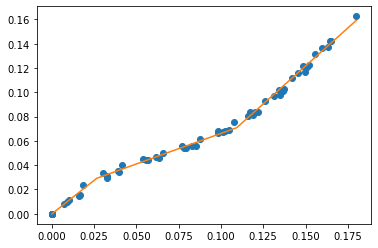

In [6]:
# set up the break point locations
x0 = np.zeros(number_of_line_segments + 1)
x0[0] = np.min(x)
x0[-1] = np.max(x)
x0[1:-1] = res

# calculate the parameters based on the optimal break point locations
my_pwlf.fit_with_breaks(x0)

# predict for the determined points
xHat = np.linspace(min(x), max(x), num=10000)
yHat = my_pwlf.predict(xHat)

plt.figure()
plt.plot(x, y, 'o')
plt.plot(xHat, yHat, '-')
plt.show()

In [7]:
my_pwlf.calc_slopes()

array([1.10704555, 0.50206765, 1.24978354])

In [8]:
# the maximum slope is less than max_slope!
# this would not be possible without the constrained fit!